In [41]:
import pandas as pd 
import psycopg
import numpy as np
import math
from datetime import timedelta
import matplotlib.pyplot as plt

In [42]:
conn = psycopg.connect(
    host='localhost',
    port=5432,
    user='postgres',
    password='fraggy',
    dbname='postgres',
)

products = pd.read_sql("select * from scm.products", conn)
sales_orders = pd.read_sql("select * from scm.sales_orders", conn)
resources = pd.read_sql("select * from scm.resources", conn)
calendar = pd.read_sql("select * from scm.calendar", conn)
standard_operations = pd.read_sql("select * from scm.standard_operations", conn)
customers = pd.read_sql("select * from scm.customers", conn)

print(resources)

cur = conn.cursor()

   resource_id         description  status created_date
0            1  Прокатный стан г/п       1   2025-12-09
1            2   Агрегат травления       1   2025-12-09
2            3  Прокатный стан х/п       1   2025-12-09
3            4          Отжиг в КП       1   2025-12-09
4            5   Линия дрессировки       1   2025-12-09
5            6           Линия АНО       1   2025-12-09
6            7       Агрегат резки       1   2025-12-09
7            8      Линия упаковки       1   2025-12-09


C:\Users\Gaming\AppData\Local\Temp\ipykernel_25712\893444078.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products = pd.read_sql("select * from scm.products", conn)
C:\Users\Gaming\AppData\Local\Temp\ipykernel_25712\893444078.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_orders = pd.read_sql("select * from scm.sales_orders", conn)
C:\Users\Gaming\AppData\Local\Temp\ipykernel_25712\893444078.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  resources = pd.read_sql("select * from scm.resources", conn)
C

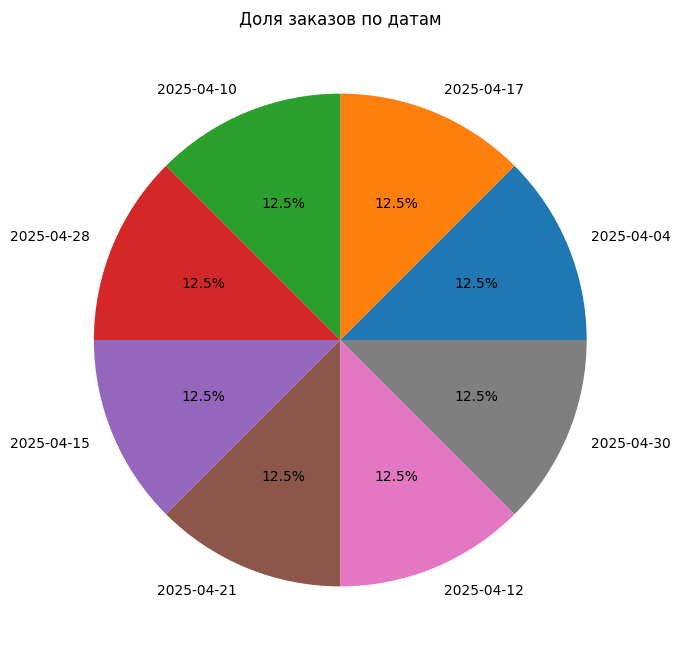

In [52]:
cur.execute("""select due_date, count(*)
from "scm".sales_orders so
group by (due_date)""")

rows = cur.fetchall()         
cols = [desc[0] for desc in cur.description] 
df = pd.DataFrame(rows, columns=cols) 

plt.figure(figsize=(8, 8))

plt.pie(
    df["count"],
    labels=df["due_date"], 
    autopct="%1.1f%%",
)

plt.title("Доля заказов по датам")
plt.show()

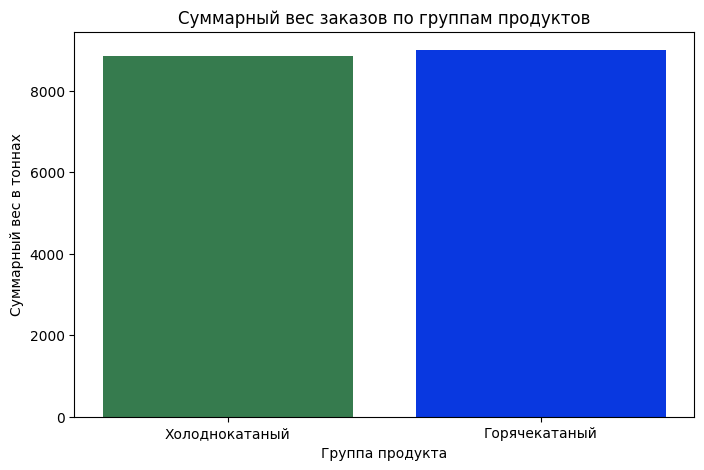

In [54]:
cur.execute("""select p.group_id, sum(so.so_weight)
from "scm".products p 
join "scm".sales_orders so on so.product_id = p.product_id
group by (p.group_id)
order by (group_id)""")
rows = cur.fetchall()
cols = [desc[0] for desc in cur.description]
df1 = pd.DataFrame(rows, columns=cols)

df1["group_name"] = df1["group_id"].map({
    1: "Холоднокатаный",
    2: "Горячекатаный"
})

plt.figure(figsize=(8, 5))
plt.bar(df1["group_name"], df1["sum"], color=["#367B4E", "#0938E0"])
plt.title("Суммарный вес заказов по группам продуктов")
plt.xlabel("Группа продукта")
plt.ylabel("Суммарный вес в тоннах")

plt.show()

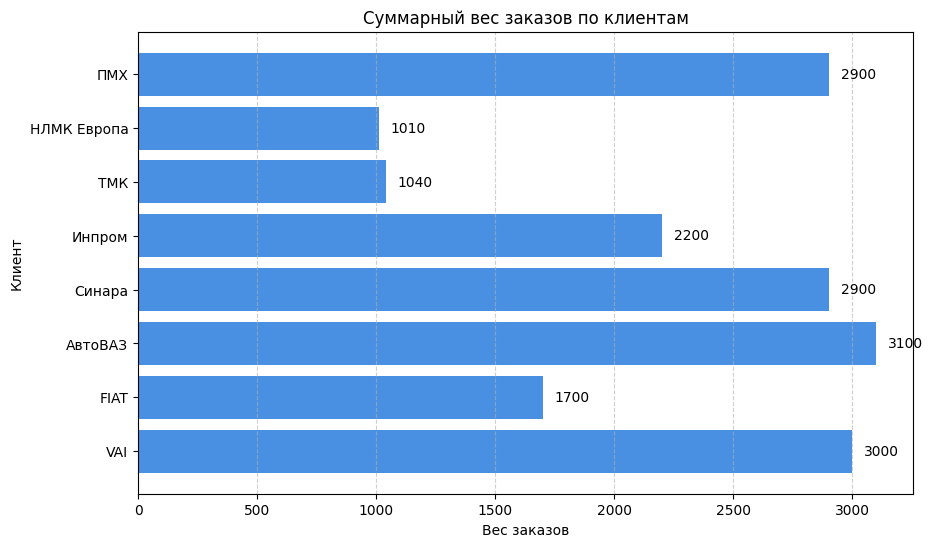

In [ ]:
cur.execute("""select c.description, so.so_weight
from "scm".customers c 
join "scm".sales_orders so on so.customer_id = c.customer_id""")
rows = cur.fetchall()
cols = [desc[0] for desc in cur.description]
df2 = pd.DataFrame(rows, columns=cols)

plt.figure(figsize=(10, 6))

plt.barh(df2["description"], df2["so_weight"], color="#4A90E2")

plt.title("Суммарный вес заказов по клиентам")
plt.xlabel("Вес заказов")
plt.ylabel("Клиент")

for index, value in enumerate(df2["so_weight"]):
    plt.text(value + 50, index, str(value), va='center')

plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

In [48]:
import pandas as pd
import numpy as np
from datetime import timedelta

import pandas as pd
import numpy as np
from datetime import timedelta


def mrp_plan_calculate(sales_orders_df, ops_df, calendar_df):
    orders = sales_orders_df.copy()
    ops = ops_df.copy()
    calendar = calendar_df.copy()

    calendar["calendar_date"] = pd.to_datetime(calendar["calendar_date"])
    calendar["capacity_available"] = 0.0
    calendar.set_index(["calendar_date", "resource_id"], inplace=True)
    order_details = []

    orders_sorted = orders.sort_values(by=["priority", "due_date"])

    for _, order in orders_sorted.iterrows():
        order_id = str(order["order_id"])
        product_id = order["product_id"]
        due_date = pd.to_datetime(order["due_date"])
        unit_weight = order["unit_weight"]
        so_weight = order["so_weight"]
        tolerance = order["tolerance"]

        num_batches = so_weight / unit_weight

        if (so_weight - np.floor(num_batches) * unit_weight) <= tolerance:
            num_batches = np.floor(num_batches)
        else:
            num_batches = np.ceil(num_batches)

        final_weight = num_batches * unit_weight
        product_ops = ops[ops["product_id"] == product_id].sort_values("operation_id")

        operations_time = []
        current_weight = final_weight

        for _, operation in product_ops.iloc[::-1].iterrows():
            op_yield = operation["yield"]
            productivity = operation["productivity"]
            resource_id = operation["resource_id"]

            current_weight /= op_yield
            op_batches = np.ceil(current_weight / unit_weight)
            current_weight = op_batches * unit_weight

            time_needed = current_weight / productivity

            operations_time.append({
                "resource_id": resource_id,
                "time_consumed": time_needed,
                "step_weight": current_weight,
                "order_id": order_id,
                "product_id": product_id,
                "productivity": productivity
            })

        current_date = due_date
        day_buffer = 24.0

        for op in operations_time:
            time_left = op["time_consumed"]
            productivity = op["productivity"]
            resource_id = op["resource_id"]

            while time_left > 0.0001:
                idx = (current_date, resource_id)

                if idx in calendar.index:
                    available = calendar.at[idx, "available_hours"]
                    used = calendar.at[idx, "capacity_available"]

                    fits_resource = (used + time_left) < available
                    fits_day = (day_buffer - time_left) >= 0

                    if fits_resource and fits_day:
                        part = time_left

                        calendar.at[idx, "capacity_available"] = used + part
                        order_details.append({
                            "order_id": op["order_id"],
                            "product_id": op["product_id"],
                            "resource_id": resource_id,
                            "date": current_date,
                            "weight": part * productivity,
                            "time": part,
                            "unit_weight": unit_weight
                        })

                        day_buffer -= part
                        time_left = 0

                    elif fits_resource and not fits_day:
                        part = (np.floor((day_buffer * productivity) / unit_weight) * unit_weight) / productivity \
                               if not ((day_buffer * productivity) / unit_weight).is_integer() else day_buffer

                        if part > 0:
                            calendar.at[idx, "capacity_available"] = used + part
                            order_details.append({
                                "order_id": op["order_id"],
                                "product_id": op["product_id"],
                                "resource_id": resource_id,
                                "date": current_date,
                                "weight": part * productivity,
                                "time": part,
                                "unit_weight": unit_weight
                            })

                            time_left -= part

                        day_buffer = 24.0
                        current_date -= timedelta(days=1)

                    else:
                        allowed = min(available - used, day_buffer)

                        part = (np.floor((allowed * productivity) / unit_weight) * unit_weight) / productivity \
                               if not ((allowed * productivity) / unit_weight).is_integer() else allowed

                        if part > 0 and part <= time_left + 0.0001:
                            calendar.at[idx, "capacity_available"] = used + part
                            order_details.append({
                                "order_id": op["order_id"],
                                "product_id": op["product_id"],
                                "resource_id": resource_id,
                                "date": current_date,
                                "weight": part * productivity,
                                "time": part,
                                "unit_weight": unit_weight
                            })

                            time_left -= part

                        day_buffer = 24.0
                        current_date -= timedelta(days=1)

                else:
                    current_date -= timedelta(days=1)
                    day_buffer = 24.0

    calendar = calendar.reset_index()
    details_df = pd.DataFrame(order_details)

    mrp_plan = details_df.groupby(["order_id", "resource_id", "date", "product_id", "unit_weight"]) \
        .agg({"weight": "sum", "time": "sum"}) \
        .reset_index()
    

    mrp_plan["quantity"] = (mrp_plan["weight"] / mrp_plan["unit_weight"]).astype(int)
    mrp_plan["date"] = mrp_plan["date"].dt.date
    mrp_plan["weight"] = mrp_plan["weight"].astype(int)

    return calendar, mrp_plan


final_calendar, mrp_plan = mrp_plan_calculate(sales_orders, standard_operations, calendar)

print("MRP План")
mrp_plan.sort_values(by=['date'],inplace=True)
mrp_plan



MRP План


,order_id,resource_id,date,product_id,unit_weight,weight,time,quantity
45,SO1007,1,2025-04-01,1,9,1782,9.378947,198
46,SO1007,2,2025-04-01,1,9,1422,7.900000,158
47,SO1007,2,2025-04-02,1,9,324,1.800000,36
48,SO1007,3,2025-04-02,1,9,1746,8.314286,194
49,SO1007,4,2025-04-02,1,9,693,13.860000,77
50,SO1007,4,2025-04-03,1,9,1035,20.700000,115
51,SO1007,5,2025-04-03,1,9,602,3.173684,66
52,SO1007,5,2025-04-04,1,9,1125,5.921053,125
54,SO1007,8,2025-04-04,1,9,1692,9.400000,188
53,SO1007,7,2025-04-04,1,9,1728,8.640000,192


In [32]:
pivot_report = mrp_plan.pivot_table(
    index='resource_id', 
    columns='date', 
    values='weight', 
    aggfunc=lambda x: ' + '.join(x.astype(str)), 
    fill_value=''
)

result = pivot_report.join(resources.set_index('resource_id')['description'])

result = result.set_index('description')

result

,2025-04-01,2025-04-02,2025-04-03,2025-04-04,2025-04-09,2025-04-10,2025-04-11,2025-04-12,2025-04-13,2025-04-14,2025-04-15,2025-04-16,2025-04-17,2025-04-20,2025-04-21,2025-04-27,2025-04-28,2025-04-29,2025-04-30
description,,,,,,,,,,,,,,,,,,,
Прокатный стан г/п,1782,,,,1859 + 1991,1045 + 1287 + 252,2794,,,,1032,40,,2950,,360 + 1110,1944,,
Агрегат травления,1422,324,,,,2981,1672,1320,,,,1048,,1479,1420,960,2264 + 120,,
Прокатный стан х/п,,1746,,,,395,2585,,,,,1048,,,,,248 + 1080,2016,
Отжиг в КП,,693,1035,,,,583,1144,1144,77,,648,384,,,,,,
Линия дрессировки,,,602,1125,,,,,,2948,,,1032,,,,,,
Линия АНО,,,,,,,,,,,,,,,,,1065,2160,80
Агрегат резки,,,,1728,,,,,,1364,1584,,1032,,,,1065,,2240
Линия упаковки,,,,1692,,3094,,2992,,,2893,,1007,,2900,,1035,,2200


In [28]:
pivot_report = mrp_plan.pivot_table(
    index='resource_id', 
    columns='date', 
    values='quantity', 
    aggfunc=lambda x: ' + '.join(x.astype(str)), 
    fill_value=''
)

result = pivot_report.join(resources.set_index('resource_id')['description'])

result = result.set_index('description')

result

,2025-04-01,2025-04-02,2025-04-03,2025-04-04,2025-04-09,2025-04-10,2025-04-11,2025-04-12,2025-04-13,2025-04-14,2025-04-15,2025-04-16,2025-04-17,2025-04-20,2025-04-21,2025-04-27,2025-04-28,2025-04-29,2025-04-30
description,,,,,,,,,,,,,,,,,,,
Прокатный стан г/п,198,,,,143 + 181,95 + 99 + 22,254,,,,129,5,,295,,45 + 74,243,,
Агрегат травления,158,36,,,,271,152,120,,,,131,,147,142,64,283 + 8,,
Прокатный стан х/п,,194,,,,35,235,,,,,131,,,,,31 + 72,252,
Отжиг в КП,,77,115,,,,53,104,104,7,,81,48,,,,,,
Линия дрессировки,,,66,125,,,,,,268,,,129,,,,,,
Линия АНО,,,,,,,,,,,,,,,,,71,270,10
Агрегат резки,,,,192,,,,,,124,144,,129,,,,71,,280
Линия упаковки,,,,188,,238,,272,,,263,,125,,290,,69,,275


In [29]:
mrp_plan['time'] = mrp_plan['time'].round(2)

pivot_report = mrp_plan.pivot_table(
    index='resource_id', 
    columns='date', 
    values='time', 
    aggfunc=lambda x: ' + '.join(x.astype(str)), 
    fill_value=''
)

result = pivot_report.join(resources.set_index('resource_id')['description'])

result = result.set_index('description')

result

,2025-04-01,2025-04-02,2025-04-03,2025-04-04,2025-04-09,2025-04-10,2025-04-11,2025-04-12,2025-04-13,2025-04-14,2025-04-15,2025-04-16,2025-04-17,2025-04-20,2025-04-21,2025-04-27,2025-04-28,2025-04-29,2025-04-30
description,,,,,,,,,,,,,,,,,,,
Прокатный стан г/п,9.38,,,,9.78 + 10.48,5.5 + 6.77 + 1.33,14.71,,,,5.43,0.21,,15.53,,1.89 + 5.84,10.23,,
Агрегат травления,7.9,1.8,,,,16.56,9.29,7.33,,,,5.82,,8.22,7.89,5.33,12.58 + 0.67,,
Прокатный стан х/п,,8.31,,,,1.89,12.31,,,,,4.99,,,,,1.18 + 5.14,9.6,
Отжиг в КП,,13.86,20.7,,,,11.66,22.88,22.88,1.54,,12.96,7.68,,,,,,
Линия дрессировки,,,3.17,5.92,,,,,,15.52,,,5.43,,,,,,
Линия АНО,,,,,,,,,,,,,,,,,7.1,14.4,0.53
Агрегат резки,,,,8.64,,,,,,6.82,7.92,,5.16,,,,5.32,,11.2
Линия упаковки,,,,9.4,,17.19,,16.62,,,16.07,,5.6,,16.11,,5.75,,12.22
